<a href="https://colab.research.google.com/github/JohannRannou/TD3bis/blob/main/TD_3_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification des propriétés d’un pli UD carbone/epoxy




Le travail consiste à identifier les propriétés élastiques d’un pli UD préimprégné T700/M21 de Hexcel. Le T700/M21 est le matériau que sera utilisé pour la conception du cadre stratifié de VTT (mini-projet final).

Le dimensionnement d’un stratifié fait l’hypothèse des contraintes planes (voir cours sur le dimensionnement des stratifiés). De ce fait, seuls 4 propriétés élastiques nous intéressent : $E_{11}$, $E_{22}$, $\nu_{12}$ et $G_{12}$.

## Description des essais et des données

### Dispositif d’essai

Voici une des machines de traction électromécanique de l’Onera. On voit le mors supérieur, l’éprouvette et une caméra optique (non exploitée dans ce travail).

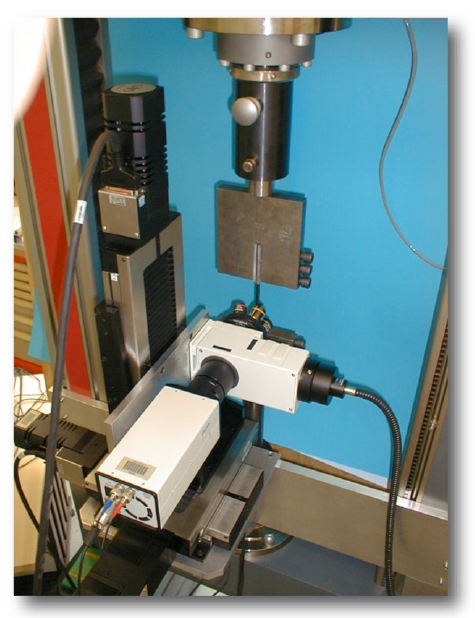


Éprouvette de composite stratifié (norme ISO 527-4 et ISO 527-5).

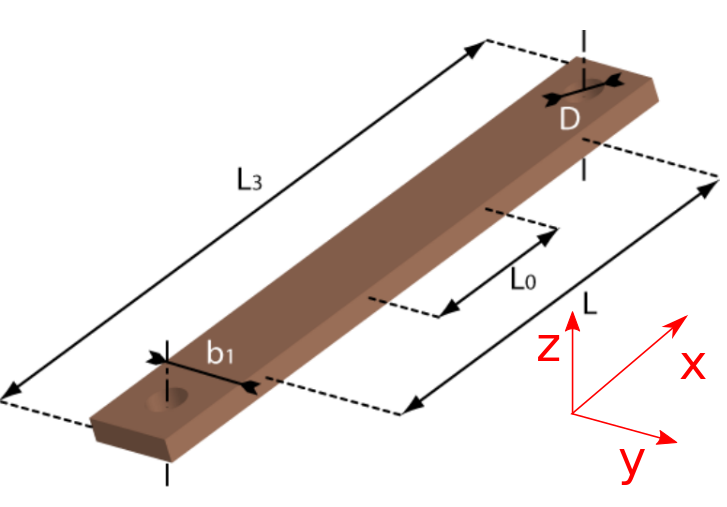


|     Long. min.     | L3 = 250mm |
|:------------------:|------------|
|  Dist. entre mors  | L = 150mm  |
| Long. de référence | L0 = 50mm  |
|       Largeur      | b1 = 25mm  |

Nous avons à notre disposition trois types d’essais :

 1.   essais de traction ou compression sur un empilement $[0]_8$ (traction sens fibre)
 2.   essais de traction sur un empilement $[90]_8$ (traction à 90)
 3.   essais de traction sur un empilement $[\pm45]_{2s}$

Chaque pli a une épaisseur de 0.26mm.

Sur chacun de ces essais sont mesurées :

*    la force de la traverse
*    la déformation sur la zone utile de l’éprouvette
  *        composante $\varepsilon_{xx}$
  *      composante $\varepsilon_{yy}$



### Données d’essais

Les données d’essais sont disponibles dans des fichiers .csv (comma seperated values). Ce sont des fichiers texte qui contiennent des en-têtes commentés par des # qui décrivent les données. Ces fichiers sont disponibles ici :https://github.com/JohannRannou/TD3bis/tree/main/Experimental_data


Plusieurs essais ont été réalisés, les noms de fichiers vérifient la nomenclature suivante :

T700_M21_X-Y.csv

où X vaut soit `0` soit `90`soit `pm45` suivant le type d’essai et où Y est le numéro de l’essai quand celui-ci a été répété.


# Travail demandé




## Identification des propriétés élastiques à partir d’essais

Il s’agit ici d’utiliser Python afin de tracer la réponse des essais et de les exploiter. On tâchera d’automatiser les différentes procédures.


Il vous est donc demandé :

* De tracer la réponse contrainte-déformation de tous les essais. 
* De calculer le module $E_{11}$
* De calculer le module $E_{22}$
* De calculer le coefficient $\nu_{12}$
* De calculer le module $G_{12}$. On admettra pour l’instant que sur un essai à $[\pm45]_{2s}$ , $G_{12}$ se calcule de la sorte (ce sera vu plus loin en cours):

    $G_{12} = \frac{\sigma}{2(\varepsilon_{xx}-\varepsilon_{yy})}$



## Exemple du tracé d'une réponse expérimentale

On charge tous les modules dont on aura besoin

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
# Pour google collab
!pip install ipympl
%matplotlib widget

try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ModuleNotFoundError:
    pass


On renseigne les dimensions de l'éprouvette

In [2]:
#Largeur d'éprouvette en mm
b = 25
e = 0.26*8
S=b*e

On récupère le fichier d'essai et on charge ses colonnes dans des vecteurs numpy (aller lire le fichier .csv brut pour mieux comprendre)

In [3]:
test_1_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_0-1.csv'
exx_1, eyy_1, force_1 = np.loadtxt(test_1_url, delimiter=',', unpack=True)
sigxx_1 = force_1/S


On trace les données brutes dans un graphe

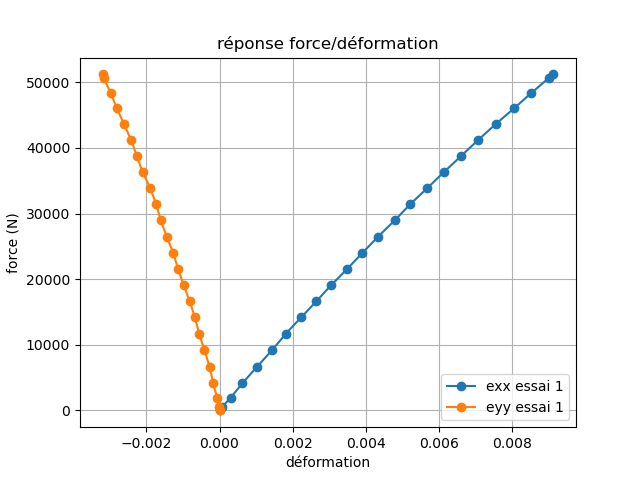

In [4]:
plt.plot(exx_1, force_1, 'o-', alpha=1, label='exx essai 1')
plt.plot(eyy_1, force_1, 'o-', alpha=1, label='eyy essai 1')

plt.legend()
plt.grid()

plt.xlabel('déformation')
plt.ylabel('force (N)')
plt.title('réponse force/déformation')
plt.grid('both')



Définition d'une fonction permettant de "fitter" le module par régression linéaire. Ce sera plus facile de calculer les modules.

In [8]:
import scipy as sp
from scipy.stats import linregress

def fit_over_range(x, y, xrange=[-np.inf, np.inf]):
    """
    Permet de fiter une fonction affine sur une plage de x limitée
    Le paramètre xrange vaut par défaut [-infini, +infini]. 
    Mais en argument on peut par exemple restreindre le fit sur [0, 0.01]
    On retourne le module
    """
    restriction = np.nonzero((x>=xrange[0]) * (x<=xrange[1]))
    try:
      module, intercept, r_value, p_value, std_err = linregress(x[restriction], y[restriction])
    except ValueError:
      module = 0
      print("Attention, le range n'est pas bon") 
    return module


In [11]:
module_x = fit_over_range(exx_1, force_1/S, [-0.004, 0])
plt.plot(exx_1, force_1/S, 'o-', color='tab:blue',alpha=1, label='exx essai 1')
plt.plot(exx_1, exx_1*module_x, '-', color='tab:blue', label='fit. coeff = {:.0f}'.format(module_x))

module_y = fit_over_range(eyy_1, force_1/S, [0., 0.001])
plt.plot(eyy_1, force_1/S, 'o-', color='tab:orange', alpha=1, label='exx essai 1')
plt.plot(eyy_1, eyy_1*module_y, '-', color='tab:orange', label='fit. coeff = {:.0f}'.format(module_y))

plt.legend()
plt.grid()
plt.xlabel('déformation')
plt.ylabel('contrainte')
plt.title('réponse contrainte/déformation')



Text(0.5, 1.0, 'réponse contrainte/déformation')

In [7]:
# On écrit une fonction qui synthétise ce qui vient d'être fait
# afin d'éviter d'avoir à tout réécrire à chaque fois.
def process_sample(file_url, range, name):
  plt.figure()
  exx, eyy, force = np.loadtxt(file_url, delimiter=',', unpack=True)
  sigxx = force/S

  module = fit_over_range(exx, force/S, range)

  plt.plot(exx, sigxx, 'o-', color='tab:blue',alpha=1, label='exx')
  plt.plot(exx, exx*module, '-', color='tab:blue', label='fit. coeff = {:.0f}'.format(module))

  plt.plot(eyy, sigxx, 'o-', color='tab:orange', alpha=1, label='eyy')

  plt.legend()
  plt.grid()
  plt.xlabel('déformation')
  plt.ylabel('contrainte')
  plt.title(name)


## Tracé de toutes les données brutes des essais




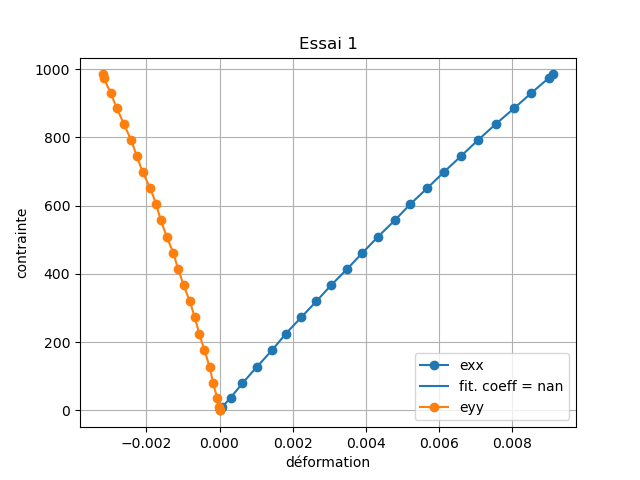

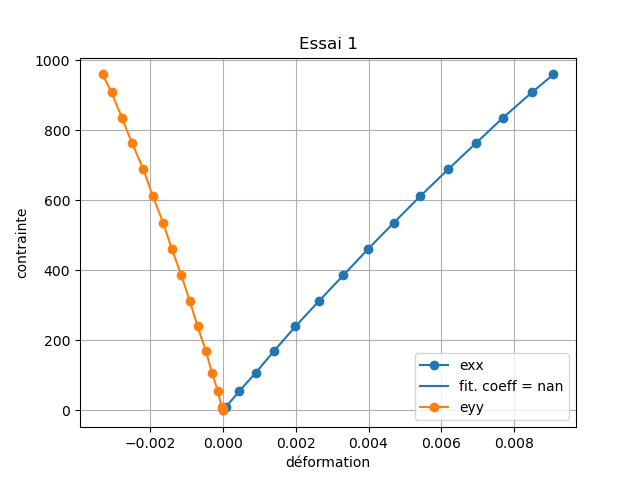

In [ ]:
# La ligne suivante permet en principe d'avoir un graphe interactif.
# mais avec google collab, ça semble ne pas fonctionner (à date)
#%matplotlib notebook

test_1_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_0-1.csv'
process_sample(test_1_url, [-0.004, 0], 'Essai 1')
test_2_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_0-2.csv'
process_sample(test_2_url, [-0.004, 0], 'Essai 2')

test_3_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_0-3.csv'
test_90_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_90-1.csv'
test_pm45_url = 'https://raw.githubusercontent.com/JohannRannou/TD3bis/main/Experimental_data/T700_M21_pm45-1.csv'


# à compléter ...

## Résultats sur $E_{11}$ et $E_{22}$

On en conclue que :

* $E_{11} \approx $ ?
* $E_{22} \approx $ ?

Mais comment calculer $G_{12}$ ?

In [ ]:
exx, eyy, force = np.loadtxt(test_pm45_url, delimiter=',', unpack=True)

# à compléter


## Résultat sur $G_{12}$

Et donc $G_{12}\approx $?

## Calcul de $\nu_{12}$

Une première méthode :

In [ ]:
exx_1, eyy_1, force_1 = np.loadtxt(test_1_url, delimiter=',', unpack=True)
sigxx_1 = force_1/S
# à compléter

une seconde méthode

In [ ]:
for test in [test_1_url, test_2_url, test_3_url]:
  exx_1, eyy_1, force_1 = np.loadtxt(test, delimiter=',', unpack=True)
  sigxx_1 = force_1/S

# à compléter

## Résultats sur $\nu_{12}$

$\nu_{12} \approx$?

## Question subsidiaire : $\nu_{21}$ ?

Sur quel essai le voit-on apparaître ?
